#Import des données

In [16]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
from shapely import line_merge, MultiLineString
from shapely.geometry import Point, MultiPoint
from shapely.geometry import Polygon, MultiPolygon
import os
from google.colab import drive
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.wkt import loads
!pip install contextily
import contextily as ctx
from shapely.geometry import Point

In [17]:
drive.mount("/content/drive")
Chemin_Donnees_bornes : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Bornes_recharge/consolidation-etalab-schema-irve-statique-v-2.3.1-20250105_bis.csv"
df = pd.read_csv(Chemin_Donnees_bornes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-17-9401c7dd71d7>:3: DtypeWarning: Columns (13,19,20,21,22,23,24,25,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Chemin_Donnees_bornes)


In [18]:
df_bornes = df[['idBornes','nom_amenageur','nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'consolidated_longitude', 'consolidated_latitude']]

In [19]:
Chemin_Donnees : str = "/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/TMJA_2019.csv"
df_trafic = pd.read_csv(Chemin_Donnees)

# Calcul des bornes proches de chaque section

In [10]:
def jointure_route_bornes(x, df_trafic, df_bornes):
    """
    Renvoie le DataFrame df_trafic mis à jour en ajoutant une colonne avec, pour chaque section de route, les IDs des bornes qui se trouvent à moins de x mètres.

    Parameters:
    - x (float): Distance maximale en mètres.
    - df_trafic (pd.DataFrame): DataFrame contenant les routes avec la colonne 'geometry' (LINESTRING en Lambert 93).
    - df_bornes (pd.DataFrame): DataFrame contenant les bornes avec 'consolidated_longitude' et 'consolidated_latitude'.

    Returns:
    - pd.DataFrame: DataFrame du trafic avec une colonne supplémentaire contenant les IDs des bornes proches.
    """
    df_trafic['geometry'] = df_trafic['geometry'].apply(
        lambda geom: loads(geom) if isinstance(geom, str) else geom
    )
    gdf_trafic = gpd.GeoDataFrame(df_trafic, geometry=df_trafic['geometry'], crs="EPSG:2154")

    df_bornes['geometry'] = df_bornes.apply(
        lambda row: Point(row['consolidated_longitude'], row['consolidated_latitude']), axis=1
    )
    gdf_bornes = gpd.GeoDataFrame(df_bornes, geometry=df_bornes['geometry'], crs="EPSG:4326")
    gdf_bornes = gdf_bornes.to_crs("EPSG:2154")

    borne_ids_proches = []
    for _, route in gdf_trafic.iterrows():
        distances = gdf_bornes.distance(route.geometry)
        ids_proches = gdf_bornes[distances <= x]['idBornes'].tolist()
        borne_ids_proches.append(ids_proches)

    gdf_trafic['borne_ids_proches'] = borne_ids_proches
    return gdf_trafic
res = jointure_route_bornes(500, df_trafic, df_bornes)
ids = res["borne_ids_proches"]


<ipython-input-10-2affd8549e87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bornes['geometry'] = df_bornes.apply(


KeyboardInterrupt: 

In [ ]:
#Enregistrement du résultat
#res.to_csv("/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/TMJA_2019_avec_bornes.csv", index=False)

In [15]:
#Lecture du résultat dans le cas où il est déjà enregistré
res = pd.read_csv("/content/drive/MyDrive/PIP2025_G8/Donnees/DonneesBrutes/Trafic/2019/TMJA_2019_avec_bornes.csv")
ids = res["borne_ids_proches"]

# Cartographie

<ipython-input-20-29798a96631f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bornes['geometry'] = df_bornes.apply(
<ipython-input-20-29798a96631f>:32: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_bornes.plot(ax=ax, color='red', markersize=5, label='Bornes électriques')  # Ajouter les bornes avec des points plus petits


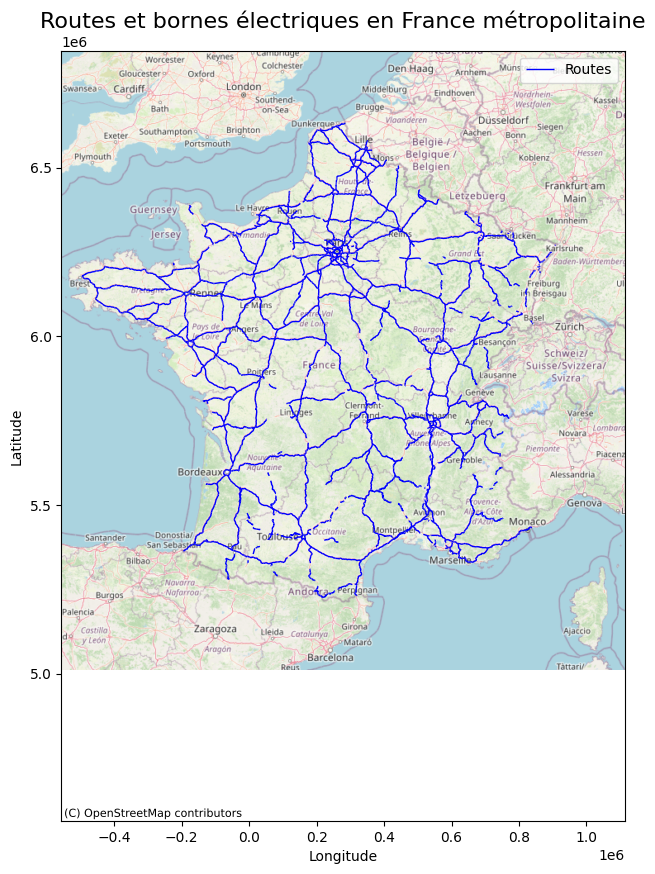

In [20]:
# Convertir la colonne 'geometry' en objets géométriques si nécessaire pour les routes
df_trafic['geometry'] = df_trafic['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)
ids_list = ids
# Filtrer les lignes à afficher pour les routes
gdf_trafic_subset = gpd.GeoDataFrame(df_trafic, geometry=df_trafic['geometry'], crs="EPSG:2154")

# Convertir les bornes en GeoDataFrame avec des points
df_bornes['geometry'] = df_bornes.apply(
    lambda row: Point(row['consolidated_longitude'], row['consolidated_latitude']), axis=1
)
gdf_bornes = gpd.GeoDataFrame(df_bornes, geometry=df_bornes['geometry'], crs="EPSG:4326")
gdf_bornes = gdf_bornes[gdf_bornes['idBornes'].isin([x for xs in ids_list for x in xs ])]

# Filtrer les bornes pour conserver uniquement celles en France métropolitaine
bbox_metropole = {
    "minx": -5.0,  # Longitude minimale (Ouest)
    "maxx": 10.0,  # Longitude maximale (Est)
    "miny": 41.0,  # Latitude minimale (Sud)
    "maxy": 61.5   # Latitude maximale (Nord)
}
gdf_bornes = gdf_bornes.cx[bbox_metropole["minx"]:bbox_metropole["maxx"], bbox_metropole["miny"]:bbox_metropole["maxy"]]

# Reprojection vers EPSG:3857 pour les deux GeoDataFrames
gdf_trafic_subset = gdf_trafic_subset.to_crs("EPSG:3857")
gdf_bornes = gdf_bornes.to_crs("EPSG:3857")

# Tracer les routes et les bornes
fig, ax = plt.subplots(figsize=(10, 10))
gdf_trafic_subset.plot(ax=ax, color='blue', linewidth=1, label='Routes')  # Tracer les routes
gdf_bornes.plot(ax=ax, color='red', markersize=5, label='Bornes électriques')  # Ajouter les bornes avec des points plus petits

# Ajouter un fond de carte OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_trafic_subset.crs.to_string())

# Ajuster les limites de la carte pour la France métropolitaine
ax.set_xlim(bbox_metropole["minx"] * 111319.5, bbox_metropole["maxx"] * 111319.5)  # Conversion degrés -> mètres pour EPSG:3857
ax.set_ylim(bbox_metropole["miny"] * 111319.5, bbox_metropole["maxy"] * 111319.5)

# Ajouter des légendes et un titre
ax.set_title("Routes et bornes électriques en France métropolitaine", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()


In [ ]:
df_trafic['geometry'] = df_trafic['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)

gdf_trafic_subset = gpd.GeoDataFrame(df_trafic, geometry=df_trafic['geometry'], crs="EPSG:2154")
df_bornes = df_bornes.copy()
df_bornes['geometry'] = df_bornes.apply(
    lambda row: Point(row['consolidated_longitude'], row['consolidated_latitude']), axis=1
)
gdf_bornes = gpd.GeoDataFrame(df_bornes, geometry=df_bornes['geometry'], crs="EPSG:4326")

#Filtrer sur les bornes qui sont proches de nos routes
gdf_bornes = gdf_bornes[gdf_bornes['idBornes'].isin([x for xs in ids.values for x in xs])]
bbox_metropole = {
    "minx": -5.0,
    "maxx": 10.0,
    "miny": 41.0,
    "maxy": 51.5
}
gdf_bornes = gdf_bornes.cx[bbox_metropole["minx"]:bbox_metropole["maxx"], bbox_metropole["miny"]:bbox_metropole["maxy"]]

#Projection des routes en format GPS
gdf_trafic_subset = gdf_trafic_subset.to_crs("EPSG:4326")

#Centrer sur la France
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

#ajouter roures
for _, row in gdf_trafic_subset.iterrows():
    if row['geometry'].geom_type == 'LineString':
        folium.PolyLine(
            locations=[(coord[1], coord[0]) for coord in row['geometry'].coords],
            color='blue',
            weight=2,
            opacity=0.8
        ).add_to(m)
    elif row['geometry'].geom_type == 'MultiLineString':
        #on utilise .geoms pour itérer sur les LineString dans un MultiLineString
        for line in row['geometry'].geoms:
            folium.PolyLine(
                locations=[(coord[1], coord[0]) for coord in line.coords],
                color='blue',
                weight=2,
                opacity=0.8
            ).add_to(m)

for _, row in gdf_bornes.iterrows():
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],
        icon=folium.Icon(color='blue', icon='plus', prefix='fa'),  # Icône en forme de croix
        popup=f"Borne ID: {row['idBornes']}"
    ).add_to(m)

m.save("carte_interactive.html")
m


NameError: name 'df_trafic' is not defined

In [ ]:
import folium
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.colors as colors

# Préparer les données
df_trafic['geometry'] = df_trafic['geometry'].apply(
    lambda geom: loads(geom) if isinstance(geom, str) else geom
)

gdf_trafic_subset = gpd.GeoDataFrame(df_trafic, geometry=df_trafic['geometry'], crs="EPSG:2154")
df_bornes = df_bornes.copy()
df_bornes['geometry'] = df_bornes.apply(
    lambda row: Point(row['consolidated_longitude'], row['consolidated_latitude']), axis=1
)
gdf_bornes = gpd.GeoDataFrame(df_bornes, geometry=df_bornes['geometry'], crs="EPSG:4326")

# Filtrer sur les bornes qui sont proches de nos routes
gdf_bornes = gdf_bornes[gdf_bornes['idBornes'].isin([x for xs in ids.values for x in xs])]
bbox_metropole = {
    "minx": -5.0,
    "maxx": 10.0,
    "miny": 41.0,
    "maxy": 51.5
}
gdf_bornes = gdf_bornes.cx[bbox_metropole["minx"]:bbox_metropole["maxx"], bbox_metropole["miny"]:bbox_metropole["maxy"]]

# Projection des routes en format GPS
gdf_trafic_subset = gdf_trafic_subset.to_crs("EPSG:4326")

# Préparer une palette pour la variable TMJA
tmja_values = gdf_trafic_subset['TMJA']
norm = colors.Normalize(vmin=tmja_values.min(), vmax=tmja_values.max())
cmap = cm.get_cmap('viridis')  # Choix d'une palette adaptée pour les variations de trafic

# Créer la carte
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

# Ajouter les routes à la carte
for _, row in gdf_trafic_subset.iterrows():
    if row['geometry'].geom_type == 'LineString':
        color = colors.to_hex(cmap(norm(row['TMJA'])))
        folium.PolyLine(
            locations=[(coord[1], coord[0]) for coord in row['geometry'].coords],
            color=color,
            weight=3,
            opacity=0.8
        ).add_to(m)
    elif row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry'].geoms:
            color = colors.to_hex(cmap(norm(row['TMJA'])))
            folium.PolyLine(
                locations=[(coord[1], coord[0]) for coord in line.coords],
                color=color,
                weight=3,
                opacity=0.8
            ).add_to(m)



# Sauvegarder et afficher la carte
m.save("carte_interactive.html")
m


NameError: name 'df_trafic' is not defined

In [ ]:
import folium
from shapely.geometry import Point

m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['consolidated_latitude'], row['consolidated_longitude']],
        radius=1,
        color='red',
        fill=True,
        fill_opacity=0.8
    ).add_to(m)
m.save("bornes_interactives.html")
m


KeyboardInterrupt: 